In [1]:
from numpy import *
import numpy as np
import math
import pickle
import pyfftw
from IPython.display import display, Markdown, Math
from datetime import datetime
from matplotlib.pyplot import *

In [2]:
#Constants
G=6.67428*10**-8; # cm^3 g^-1 s^-2
kpc=3.085678*10**21; # 1kpc = 3.08 10^21 cm
mass=10**7*2.0*10**33; # 10^7 solar mass = 2 10^33 g with ~10^4 stars


In [3]:
F = open("Positions_stars_3D.txt", "r")
F.seek(0)

numStars=0
while F.readline() :
    numStars+=1
    
F.close()

F = open("Positions_stars_3D.txt", "r")
star_positions = np.zeros(shape=(numStars,3))
for i in range (numStars-1):
    str_list = F.readline()
    new_list = str_list.split()

    star_positions[i][0] = float(new_list[0])
    star_positions[i][1] = float(new_list[1])
    star_positions[i][2] = float(new_list[2])
F.close()

print(numStars)
print(star_positions[1000][2])

10240
0.0


In [4]:
numPoints = 256

In [5]:
# Compute the spacing of all cells
Max=np.max(star_positions, axis=0)
Min=np.min(star_positions, axis=0)

Max_x=Max[0]
Min_x=Min[0]
Max_y=Max[1]
Min_y=Min[1]
Max_z=Max[2]
Min_z=Min[2]



if (Max_x>abs(Min_x)):
    space_x=Max_x/(numPoints/2)
    add_correction_x=0
else:
    space_x=abs(Min_x)/(numPoints/2)
    add_correction_x=1

if (Max_y>abs(Min_y)):
    space_y=Max_y/(numPoints/2)
    add_correction_y=0
else:
    space_y=abs(Min_y)/(numPoints/2)
    add_correction_y=1
    
if (Max_z>abs(Min_z)):
    space_z=Max_z/(numPoints/2)
    add_correction_z=0
else:
    space_z=abs(Min_z)/(numPoints/2)
    add_correction_z=1
    
print(space_x)
print(space_y)
print(space_z)
print(add_correction_x)
print(add_correction_y)
print(add_correction_z)

0.200826890625
0.1719680703125
0.0018107421875
1
1
1


In [6]:
TYPE = "complex128"
# Initialization of Green and density
green_grid = pyfftw.empty_aligned((numPoints,numPoints,numPoints), dtype=TYPE)
density_grid = pyfftw.empty_aligned((numPoints,numPoints,numPoints), dtype=TYPE)

In [7]:
# Computing the density for each cell with Cloud-in-cell method
for i in range (numStars-1):
    #Computing node positions on mesh
    #floor takes each element of the array to the nearest integer less than or equal to 
    #that element
    #Une sorte de normalisation des valeurs de x pour leur assigner une coordonnée en i,j avec
    #i et j allant de 0 a 255
    
    node_x = int(math.floor(star_positions[i][0]/space_x) + (numPoints/2 + add_correction_x))-1
    node_y = int(math.floor(star_positions[i][1]/space_y) + (numPoints/2 + add_correction_y))-1
    node_z = int(math.floor(star_positions[i][2]/space_z) + (numPoints/2 + add_correction_z))-1
    
    #Set the CIC size fractions using fmod 
    dx = math.fmod(abs(star_positions[i][0]),space_x)/space_x
    dy = math.fmod(abs(star_positions[i][1]),space_y)/space_y
    dz = math.fmod(abs(star_positions[i][2]),space_z)/space_z
    tx = 1.0 - dx
    ty = 1.0 - dy
    tz = 1.0 - dz
    
    #Adding for setting CIC size fractions
    #Version with (i,j) centered on cells
    #Begining of the mesh on x condition 
    if ((dx < 0.5) and (node_x == 0)):
        frac_x = dx
        neighboor_x = 0
        epsilon_x = 0
   #End of the mesh on x condition
    elif ((dx > 0.5) and (node_x == numPoints-1)) :
        frac_x = dx - 0.5
        neighboor_x = 0
        epsilon_x = 0
    #Not on the borders of the mesh on x
    elif (dx < 0.5):
        frac_x = dx + 0.5
        neighboor_x = -1
        epsilon_x = 1
    else : 
        frac_x = tx + 0.5
        neighboor_x = 1
        epsilon_x = 1
    
    #Begining of the mesh on y condition 
    if ((dy < 0.5) and (node_y == 0)):
        frac_y = dy
        neighboor_y = 0
        epsilon_y = 0
    #End of the mesh on y condition 
    elif ((dy > 0.5) and (node_y == numPoints-1)):
        frac_y = dy - 0.5
        neighboor_y = 0
        epsilon_y = 0
    #Not on the borders of the mesh on y
    elif (dy < 0.5):
        frac_y = dy + 0.5
        neighboor_y = -1
        epsilon_y = 1
    else: 
        frac_y = ty + 0.5
        neighboor_y = 1
        epsilon_y = 1
    
    #Begining of the mesh on z condition 
    if ((dz < 0.5) and (node_z == 0)):
        frac_z = dz
        neighboor_z = 0
        epsilon_z = 0
    #End of the mesh on y condition 
    elif ((dz > 0.5) and (node_z == numPoints-1)):
        frac_z = dz - 0.5
        neighboor_z = 0
        epsilon_z= 0
    #Not on the borders of the mesh on y
    elif (dz < 0.5):
        frac_z = dz + 0.5
        neighboor_z = -1
        epsilon_z = 1
    else: 
        frac_z = tz + 0.5
        neighboor_z = 1
        epsilon_z = 1
    
    #Computation of the Density with CIC fractions in each points given 
    density_grid[node_x][node_y][node_z] = density_grid[node_x][node_y][node_z] + mass*(frac_x*frac_y*frac_z)/(space_x*space_y*space_z)
    
    density_grid[node_x+neighboor_x][node_y][node_z] = density_grid[node_x+neighboor_x][node_y][node_z] + mass*(epsilon_x*(1.0-frac_x)*frac_y*frac_z)/(space_x*space_y*space_z)

    density_grid[node_x][node_y+neighboor_y][node_z] = density_grid[node_x][node_y+neighboor_y][node_z] + mass*(frac_x*epsilon_y*(1.0-frac_y)*frac_z)/(space_x*space_y*space_z)
    
    density_grid[node_x+neighboor_x][node_y+neighboor_y][node_z] = density_grid[node_x+neighboor_x][node_y+neighboor_y][node_z] + mass*(epsilon_x*(1.0-frac_x)*epsilon_y*(1.0-frac_y)*frac_z)/(space_x*space_y*space_z)
    
    density_grid[node_x][node_y][node_z+neighboor_z] = density_grid[node_x][node_y][node_z+neighboor_z] + mass*(frac_x*frac_y*epsilon_z*(1.0-frac_z))/(space_x*space_y*space_z)
    
    density_grid[node_x][node_y + neighboor_y][node_z+neighboor_z] = density_grid[node_x][node_y + neighboor_y][node_z+neighboor_z] + mass*(frac_x*epsilon_y*(1.0-frac_y)*epsilon_z*(1.0-frac_z))/(space_x*space_y*space_z)
    
    density_grid[node_x + neighboor_x][node_y][node_z+neighboor_z] = density_grid[node_x + neighboor_x][node_y][node_z+neighboor_z] + mass*(epsilon_x*(1.0-frac_x)*frac_y*epsilon_z*(1.0-frac_z))/(space_x*space_y*space_z)
    
    density_grid[node_x + neighboor_x][node_y + neighboor_y][node_z + neighboor_z] = density_grid[node_x + neighboor_x][node_y+neighboor_y][node_z+neighboor_z] + mass*(epsilon_x*(1.0-frac_x)*epsilon_y*(1.0-frac_y)*epsilon_z*(1.0-frac_z))/(space_x*space_y*space_z)

    
    
density_grid_tr = pyfftw.empty_aligned((numPoints,numPoints, numPoints), dtype=TYPE)

density_grid_tr = density_grid.T

print(node_x)
print(node_y)
print(node_z)

136
160
152


In [8]:
print(density_grid[node_x][node_y][node_z])

(2.6196019869223386e+44+0j)


In [9]:
#Computing discretized Green's function
for i in range (numPoints):
    for j in range (numPoints):
        for k in range (numPoints):
            dx = np.sqrt((i-numPoints/2-add_correction_x)*(i-numPoints/2-add_correction_x))*space_x
            dy = np.sqrt((j-numPoints/2-add_correction_y)*(j-numPoints/2-add_correction_y))*space_y
            dy = np.sqrt((k-numPoints/2-add_correction_z)*(k-numPoints/2-add_correction_z))*space_z

        #Discretized Green's function  
        if (i!=int(numPoints/2+add_correction_x) and j!=int(numPoints/2+add_correction_y) and k!=int(numPoints/2+add_correction_z)):
            green_grid[i][j][k] = -1.0/(4.0*np.pi*np.sqrt(dx*dx + dy*dy + dz*dz))
        #Avoid division by 0
        else :
            green_grid[i][j][k] = 1.0 


In [10]:
TYPE = "complex128"
tf_green = pyfftw.empty_aligned((numPoints,numPoints,numPoints), dtype=TYPE)
tf_density = pyfftw.empty_aligned((numPoints,numPoints,numPoints), dtype=TYPE)
ifft_potentiel = pyfftw.empty_aligned((numPoints,numPoints,numPoints), dtype=TYPE)

In [11]:
fft_object_green = pyfftw.FFTW(green_grid, tf_green, axes=(0,1))

fft_object_density = pyfftw.FFTW(density_grid_tr, tf_density, axes=(0,1))

tf_green = fft_object_green(green_grid)

tf_density = fft_object_density(density_grid_tr)

tf_product = pyfftw.empty_aligned((numPoints,numPoints, numPoints), dtype=TYPE)

tf_product = 4*np.pi*G*tf_green*tf_density

potential_grid = pyfftw.empty_aligned((numPoints,numPoints, numPoints), dtype=TYPE)

ifft_object_3d = pyfftw.FFTW(tf_product, potential_grid, axes=(0,1), direction="FFTW_BACKWARD")

potential = np.zeros((numPoints,numPoints,numPoints))

potential_grid = ifft_object_3d(tf_product)

potential = potential_grid.real*(space_x*space_y*space_z)/kpc

potential_shift=np.fft.fftshift(potential)

TypeError: Invalid shape (256, 256, 256) for image data

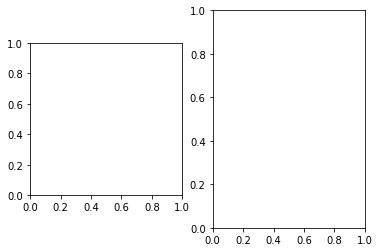

In [13]:
figures,ax = subplots(1,2)
stretch = (-(numPoints/2+add_correction_x), +numPoints/2+add_correction_x, -(numPoints/2+add_correction_x), numPoints/2+add_correction_x, )

ax[0].imshow(abs(potential_shift),extent=stretch),\

ax[1].imshow(potential,extent=stretch)
show()

In [ ]:
figures,ax = subplots(1,2)
stretch = (-(numPoints/2+add_correction_x), +numPoints/2+add_correction_x, -(numPoints/2+add_correction_x), numPoints/2+add_correction_x)

ax[0].imshow(density_grid_tr.real,extent=stretch),\

ax[1].imshow(green_grid.real,extent=stretch)
show()

In [ ]:
for i in range (numPoints):
    for j in range (numPoints):
        if (green_grid[i][j]!=0):
            print(green_grid[i][j])

In [ ]:
for i in range (numPoints):
    for j in range (numPoints):
        if (density_grid[i][j]!=0):
            print(density_grid[i][j])

In [ ]:
for i in range (numPoints):
    for j in range (numPoints):
        if (tf_product[i][j]!=0):
            print(tf_product[i][j])

In [ ]:
TYPE = "float64"

x,y = np.linspace(Min_x, Max_x, 128, dtype=TYPE), np.linspace(Min_x, Max_y, 128, dtype=TYPE)
X,Y = np.meshgrid(x, y)

In [ ]:
Potential_th = np.zeros((numPoints,numPoints))

for i in range(128):
    for j in range (128):
        Potential_th[i][j]=0.0
        #start_time = datetime.now()
        #print(start_time)
        for k in range (numStars-1):
            Potential_th[i][j]=Potential_th[i][j]-G*mass/(np.sqrt((X[i][j]-star_positions[k][0])**2+(Y[i][j]-star_positions[k][1])**2)*kpc)
        #end_time = datetime.now()
        #print(end_time)
